In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
import sklearn.svm
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
import local_models.utils
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
n = 200
K=14
noise=0.04
factor = 0.3
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=factor,
                                      noise=noise)

In [4]:
RUN = 6
project_dir = "../data/local_svm_circles_{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

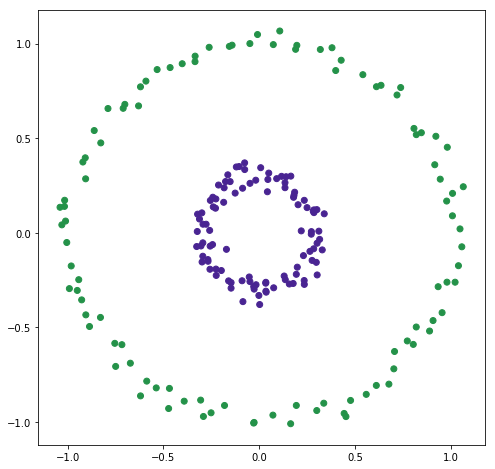

In [5]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [6]:
class ScaledGaussianKernel(local_models.local_models.GaussianKernel):
    def __init__(self, bandwidth=None, k=None, s=1.):
        super().__init__(bandwidth, k)
        self.s = s
    def __call__(self, x):
        return super().__call__(x)*self.s
    def d(self, x):
        return super().d(x)*self.s

In [7]:
help(sklearn.svm.LinearSVC)

Help on class LinearSVC in module sklearn.svm._classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : str, 'l1' or 'l2' (default='l2')
 |      Specifies the norm used in the penalization. The 'l2'
 |      penalty is the standard used in SVC. The 'l1' leads to ``coef_``
 |      vectors that are sparse.
 |  
 |  loss : str, 'hinge' or 'squared_hinge' (default=

In [8]:
#kernel = ScaledGaussianKernel(bandwidth=1.,s=1.)
kernel = local_models.local_models.GaussianKernel(bandwidth="knn", k=30)
#kernel = local_models.local_models.GaussianKernel(bandwidth=2.)
#LinearSVC does not currently support sample_weight.  The new version circa early december 2019 should.
model = sklearn.svm.LinearSVC(C=30., dual=False)
#model = sklearn.svm.SVC(C=1e3,kernel="linear")
linear_models = local_models.local_models.LocalModels(model)
linear_models.fit(noisy_circles,c)

In [9]:
RANGE_PCT = 0.1
data = noisy_circles
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = RANGE_PCT*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = ((data_ranges[:,1] - data_ranges[:,0])/20)
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], data_step[i]), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])

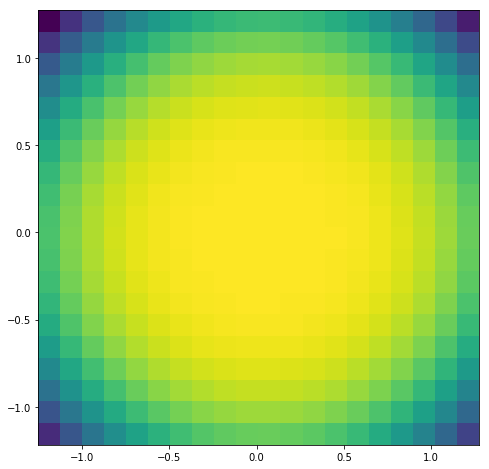

In [10]:
plt.imshow(kernel(np.sum(g.transpose(1,2,0)**2,axis=-1)), extent=data_ranges.reshape(-1))

In [11]:
xx_linear_params, the_models = linear_models.transform(xx,r=kernel.support_radius(),weighted=True,kernel=kernel, return_models=True)
xx_linear_params.shape

(400, 3)

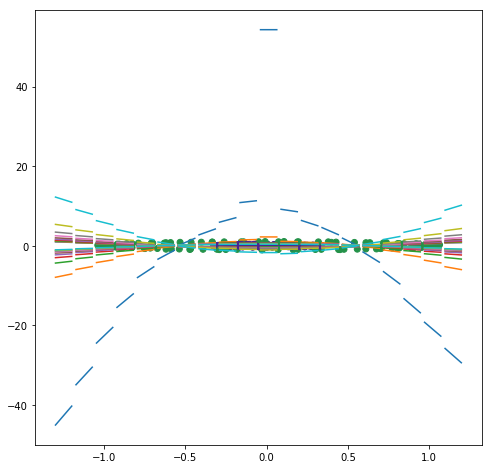

In [12]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
span = np.linspace(-0.05,0.05,3)
for i in range(xx.shape[0]):
    #x,y = noisy_circles[i]
    plt.plot(span + xx[i,0], (-xx_linear_params[i,2]-xx_linear_params[i,0]*(span+xx[i,0]))/xx_linear_params[i,1])
plt.show()

In [13]:
#perps = np.linalg.solve(xx_linear_params[:,1:2].reshape(-1,1,1), -xx_linear_params[:,0:1])
perps = np.stack((-xx_linear_params[:,1], xx_linear_params[:,0]),axis=-1)

In [14]:
#perps = np.stack((np.ones(perps.shape[0]), perps[:,0]), axis=-1)

In [15]:
#bases=xx_linear_params[:,:2].reshape(400,1,2)/np.sqrt(np.sum(xx_linear_params[:,:2]**2,axis=-1)).reshape(400,1,1)
bases=perps[:,:2].reshape(400,1,2)/np.sqrt(np.sum(perps[:,:2]**2,axis=-1)).reshape(400,1,1)

In [16]:
projected_xx = local_models.utils.linear_project_pointwise_bases(xx, bases,# perps.reshape(400,1,2),
            np.stack((np.zeros(xx_linear_params[:,2].shape), -xx_linear_params[:,2]/xx_linear_params[:,1]),axis=-1))

In [17]:
def perp2d(v):
    a,b = v
    return np.array((-b,a))/np.linalg.norm([a,b])

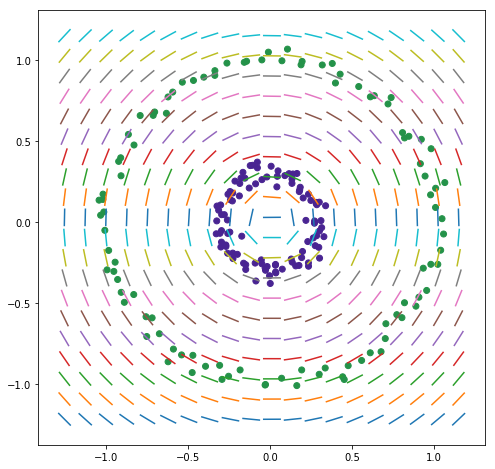

In [18]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
span = np.linspace(-0.05,0.05,3)
for i in range(xx.shape[0]):
    #x,y = noisy_circles[i]
    line = np.einsum("i,j->ij", span, perp2d(xx_linear_params[i,:2])) + xx[i]
    plt.plot(line[:,0], line[:,1])
    #plt.plot(projected_xx[i,0] + span, (-xx_linear_params[i,2]-xx_linear_params[i,0]*(span+projected_xx[i,0]))/xx_linear_params[i,1])
plt.show()

In [19]:
xx_linear_params.shape

(400, 3)

In [20]:
weird = np.argmax(np.sum((projected_xx-xx)**2, axis=1))
weird

210

In [21]:
iz,dz = linear_models.index.query_radius(xx[weird:weird+1], r=kernel.support_radius(), return_distance=True)

In [22]:
dz

array([array([1.03984356, 0.96634654, 1.01424562, 1.01810919, 1.05399989,
       0.98132712, 1.02733532, 0.9571901 , 1.0586451 , 1.00402833,
       0.97802676, 1.09245125, 1.01145729, 0.99250349, 1.0101926 ,
       1.07382053, 0.96727171, 0.3588491 , 0.40467767, 0.96152571,
       1.04512729, 1.01551095, 1.03227352, 1.03578358, 0.31571344,
       0.32896079, 0.30478316, 0.33274698, 0.30022548, 0.33132074,
       0.29304739, 0.9934512 , 0.21738586, 0.28640755, 0.33650674,
       0.31748779, 1.01418993, 0.27188031, 0.31032691, 0.34904865,
       0.33221571, 0.3537827 , 0.34754236, 0.32485102, 0.27023329,
       0.33128827, 0.32819588, 0.3607375 , 0.34288748, 1.01983089,
       0.27162296, 1.04241221, 0.30646872, 0.30311153, 0.31736836,
       0.27471773, 1.03774285, 0.26114641, 0.32122348, 0.28213541,
       0.3273658 , 1.02349772, 0.30055416, 0.29015628, 0.29254492,
       0.22959016, 0.3414483 , 0.22786947, 0.30690915, 0.2383243 ,
       1.05716883, 0.2406166 , 0.28637844, 1.03459906, 

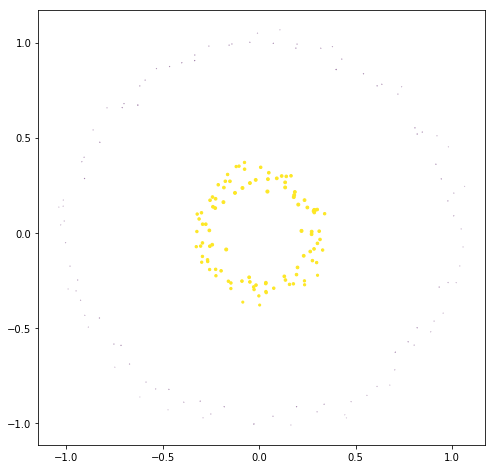

In [23]:
plt.scatter(noisy_circles[iz[0]][:,0], noisy_circles[iz[0]][:,1], c=c[iz[0]], s=30*kernel(dz[0]))

In [24]:
xx[weird]

array([0.01216919, 0.02888918])

In [25]:
projected_xx[weird]

array([-0.45169448, 54.27441036])

In [26]:
xx_linear_params[weird]

array([ 1.56343842e-04, -1.82832880e-02,  9.92385296e-01])

In [27]:
#testfit_model = sklearn.svm.SVC(C=0.0001,kernel="linear",verbose=True)
testfit_model = sklearn.svm.LinearSVC(C=30.,dual=False)

In [28]:
dz[0]

array([1.03984356, 0.96634654, 1.01424562, 1.01810919, 1.05399989,
       0.98132712, 1.02733532, 0.9571901 , 1.0586451 , 1.00402833,
       0.97802676, 1.09245125, 1.01145729, 0.99250349, 1.0101926 ,
       1.07382053, 0.96727171, 0.3588491 , 0.40467767, 0.96152571,
       1.04512729, 1.01551095, 1.03227352, 1.03578358, 0.31571344,
       0.32896079, 0.30478316, 0.33274698, 0.30022548, 0.33132074,
       0.29304739, 0.9934512 , 0.21738586, 0.28640755, 0.33650674,
       0.31748779, 1.01418993, 0.27188031, 0.31032691, 0.34904865,
       0.33221571, 0.3537827 , 0.34754236, 0.32485102, 0.27023329,
       0.33128827, 0.32819588, 0.3607375 , 0.34288748, 1.01983089,
       0.27162296, 1.04241221, 0.30646872, 0.30311153, 0.31736836,
       0.27471773, 1.03774285, 0.26114641, 0.32122348, 0.28213541,
       0.3273658 , 1.02349772, 0.30055416, 0.29015628, 0.29254492,
       0.22959016, 0.3414483 , 0.22786947, 0.30690915, 0.2383243 ,
       1.05716883, 0.2406166 , 0.28637844, 1.03459906, 0.25125

In [29]:
inverse_iz = np.empty_like(iz[0])
inverse_iz[iz[0]] = np.arange(iz[0].shape[0])

In [30]:
inverse_iz

array([  0,  85,  91, 149, 132, 147, 125, 181,  95,  24,  27, 198, 196,
       109, 197, 192,  43,  88,  54,   1,  49, 171,  75, 137,  93,  46,
        98,  97, 115,  87,  56,  38, 111, 100, 123, 127,  25,  19,   9,
        30, 161, 180, 114, 193,   2, 158, 159,  90, 142, 185, 112,  71,
       157,  31,  86, 101, 102, 164, 150,  53, 169,  10, 117,  84, 174,
       177,  74, 182,  70,  11,   3, 128, 129,  40,  28, 166, 167, 175,
       136, 156,  50, 138, 139, 184, 140, 190, 141,  77, 145,  76, 146,
        92,  32, 108,  33, 195, 121, 106,  34, 104,  22, 199, 118,  35,
       179,  16, 131,  60, 187, 188, 152,  37, 107,  12,   4,  17, 110,
        80,  73,  13,  23, 113,  52,  39,  55, 116, 105,  58,  29, 153,
        99, 119, 120, 151, 189, 172,  79, 176,  18, 178,  41,  72, 183,
       122,  14, 191,  82,  42, 194, 124,  36,  94, 126,  78, 154, 155,
        44,  61,  45,  81, 130,  89, 162, 163, 103, 165,   5,  83, 168,
         6, 170,   7,   8, 173, 133,  57, 134, 135,  15,  51,  5

In [31]:
dz[0][inverse_iz]

array([1.03984356, 1.01865372, 0.99672174, 0.26042079, 0.28283448,
       0.30916519, 0.97274501, 1.07354016, 0.99071768, 0.31571344,
       0.33274698, 0.97632848, 0.95138478, 1.00439231, 0.26437682,
       0.25335702, 0.32485102, 0.98107853, 0.31736836, 0.96634654,
       1.01983089, 0.96475411, 0.99455499, 1.04383197, 0.96965797,
       0.32819588, 0.90829704, 0.97172657, 0.28197969, 0.97569708,
       1.03774285, 0.31032691, 0.29427205, 0.29131042, 0.32569534,
       1.00927206, 0.32896079, 0.96152571, 1.00402833, 0.29304739,
       0.28725895, 0.25887562, 0.38371333, 0.97575886, 1.01424562,
       1.01830933, 0.26598792, 0.95817748, 0.30710488, 0.28940736,
       1.04648214, 0.2406166 , 0.19061604, 0.9934512 , 0.97057777,
       0.29595251, 0.34356716, 0.29301275, 0.29903816, 0.30311153,
       0.31072976, 0.97802676, 0.95889543, 1.01244505, 0.91487364,
       0.9659404 , 0.25125569, 0.30304506, 1.05716883, 1.09245125,
       1.01810919, 1.03807049, 0.3028525 , 0.33221571, 0.30022

In [32]:
iz[0]

array([  0,  19,  44,  70, 114, 166, 169, 171, 172,  38,  61,  69, 113,
       119, 144, 178, 105, 115, 138,  37, 190, 197, 100, 120,   9,  36,
       187,  10,  74, 128,  39,  53,  92,  94,  98, 103, 150, 111,  31,
       123,  73, 140, 147,  16, 156, 158,  25, 181, 182,  20,  80, 179,
       122,  59,  18, 124,  30, 175, 127, 180, 107, 157, 183, 184, 189,
       191, 192, 195, 196, 198,  68,  51, 141, 118,  66,  22,  89,  87,
       153, 136, 117, 159, 146, 167,  63,   1,  54,  29,  17, 161,  47,
         2,  91,  24, 151,   8, 199,  27,  26, 130,  33,  55,  56, 164,
        99, 126,  97, 112,  93,  13, 116,  32,  50, 121,  42,  28, 125,
        62, 102, 131, 132,  96, 143,  34, 149,   6, 152,  35,  71,  72,
       160, 106,   4, 174, 176, 177,  78,  23,  81,  82,  84,  86,  48,
       193, 194,  88,  90,   5, 185,   3,  58, 133, 110, 129, 154, 155,
        79,  52,  45,  46, 188,  40, 162, 163,  57, 165,  75,  76, 168,
        60, 170,  21, 135, 173,  64,  77, 137,  65, 139, 104,  4

In [33]:
testfit_model.fit(noisy_circles[iz[0]], c[iz[0]], sample_weight=dz[0])

LinearSVC(C=30.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [34]:
def line(coef, intercept, x):
    return x, (x*coef[0] + intercept)/(-coef[1])

In [35]:
testfit_model.coef_

array([[-0.01393008, -0.00420687]])

In [36]:
testfit_model.coef_[0,1]/testfit_model.coef_[0,0]

0.3019990588707091

In [37]:
testfit_model.intercept_

array([-0.53700895])

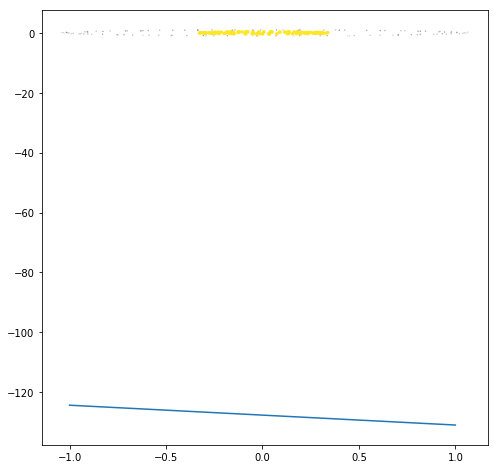

In [38]:
plt.scatter(noisy_circles[iz[0]][:,0], noisy_circles[iz[0]][:,1], c=c[iz[0]], s=30*kernel(dz[0]))
plt.plot(*line(testfit_model.coef_[0], testfit_model.intercept_, np.array([-1,1])))

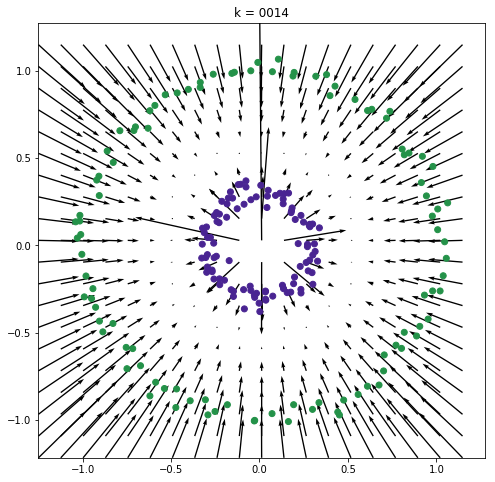

In [39]:
changes = projected_xx - xx
#pts = np.array([[1.8, 0.1]])
pts = xx
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10.)
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("k = {:04d}".format(K))

span = np.linspace(0.05,0.05,10)
pts_params = linear_models.transform(pts, r=kernel.support_radius(), weighted=True, kernel=kernel)
#for i in range(pts.shape[0]):
#    x,y = pts[i]
#    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "k_{:04d}.png".format(K)))
plt.show()

In [40]:
def linear_reject_pointwise_bases(x, bases, mean=0):
    x = x - mean #mean center everything
    projection = local_models.utils.linear_project_pointwise_bases(x, bases)
    rejection = x - projection
    rejection = rejection + mean #re-add the mean in
    return rejection

def scms(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None):
    #all_failures = []
    print(X.shape)
    if failure_delta is None:
        failure_delta = np.average(lm.index.query(X, k=2)[0][:,1])*1e4
        print("default failure delta: {}".format(failure_delta))
    for i in range(iters):
        print("scms iteration {:04d}".format(i))
        X = np.copy(X)
        Xrange = np.arange(X.shape[0])
        params = lm.transform(X, r=kernel.support_radius(), weighted=True,
            kernel=kernel)
        normalized_params = params/np.sqrt(np.sum(params[:,:X.shape[1]]**2,axis=-1,keepdims=True))
        normals = normalized_params[:,:X.shape[1]]
        intercepts = normalized_params[:,X.shape[1]]
        biggest_normal_component = np.argmax(normals, axis=1)
        biggest_normal_component_indices = np.stack((Xrange, biggest_normal_component))
        biggest_normal_component_indices = tuple(map(tuple, biggest_normal_component_indices))
        
        plane_pt_component = -intercepts/normalized_params[biggest_normal_component_indices]
        plane_pts = np.zeros(normals.shape)
        plane_pts[biggest_normal_component_indices] = plane_pt_component
        
        normals = normals.reshape(X.shape[0], 1, X.shape[1])
        new_X = linear_reject_pointwise_bases(X, normals, plane_pts)
        failures = np.sqrt(np.sum((new_X-X)**2, axis=1)) > failure_delta
        successes = np.logical_not(failures)
        X[successes] = new_X[successes]
        if constraint_space is not None:
            X[successes] = local_models.utils.linear_project_pointwise_bases(X[successes], constraint_space[0][successes], constraint_space[1][successes])

        if return_params:
            yield X, successes, normals
        else:
            yield X, successes

import traceback
import collections
def orthogonal_project_scms(X, lm, kernel, scms_iters=30, newtons_iters=30, alpha=1e-2, return_everything=False):
    #1. do scms to get *a* point on the surface, y
    #2. get the tangent plane at y
    if return_everything:
        everything = collections.defaultdict(list)
    shifter = scms(X,lm,kernel,iters=scms_iters,return_params=True)
    for y, successes, normals in shifter:
        if return_everything:
            everything[0].append((y, successes, normals))
    X = X[successes]
    y = y[successes]
    normals = normals[successes]
    #3. do scms while projecting along some convex combo of the line passing thru x and y, and 
    #   the line passing through x and along the normal vector to the tangent plane in 2 to get y'
    #4. y <- y'
    #5. GOTO 2
    for i in range(newtons_iters):
        print("newtons method iteration: {:04d}".format(i))
        print(X.shape, y.shape, normals.shape)
        try:
            Xy = y-X
            normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
            normalized_Xy = np.expand_dims(normalized_Xy, 1)
            #print("shapes", normalized_Xy.shape, normals.shape)
            surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
            constraint_vec = surface_normal_aligned_Xy*(1-alpha) + normals*alpha
            constraint_vec = constraint_vec/np.sqrt(np.sum(constraint_vec**2, axis=-1, keepdims=True))
            print("constraint shape", constraint_vec.shape)
            shifter = scms(X,lm,kernel,iters=scms_iters,return_params=True,constraint_space=(constraint_vec, X))
            for y, successes, normals in shifter:
                if return_everything:
                    everything[i+1].append((y, successes, normals))
            X = X[successes]
            y = y[successes]
            normals = normals[successes]
        except:
            traceback.print_exc()
            break
    if return_everything:
        return everything
    return X, y, normals  

In [41]:
test = orthogonal_project_scms(noisy_circles, linear_models, kernel, return_everything=True)

(200, 2)
default failure delta: 421.914747595644
scms iteration 0000
scms iteration 0001
scms iteration 0002
scms iteration 0003
scms iteration 0004
scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iteration 0010
scms iteration 0011
scms iteration 0012
scms iteration 0013
scms iteration 0014
scms iteration 0015
scms iteration 0016
scms iteration 0017
scms iteration 0018
scms iteration 0019
scms iteration 0020
scms iteration 0021
scms iteration 0022
scms iteration 0023
scms iteration 0024
scms iteration 0025
scms iteration 0026
scms iteration 0027
scms iteration 0028
scms iteration 0029
newtons method iteration: 0000
(200, 2) (200, 2) (200, 1, 2)
constraint shape (200, 1, 2)
(200, 2)
default failure delta: 421.914747595644
scms iteration 0000
scms iteration 0001
scms iteration 0002
scms iteration 0003
scms iteration 0004
scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iterati

scms iteration 0001
scms iteration 0002
scms iteration 0003
scms iteration 0004
scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iteration 0010
scms iteration 0011
scms iteration 0012
scms iteration 0013
scms iteration 0014
scms iteration 0015
scms iteration 0016
scms iteration 0017
scms iteration 0018
scms iteration 0019
scms iteration 0020
scms iteration 0021
scms iteration 0022
scms iteration 0023
scms iteration 0024
scms iteration 0025
scms iteration 0026
scms iteration 0027
scms iteration 0028
scms iteration 0029
newtons method iteration: 0011
(200, 2) (200, 2) (200, 1, 2)
constraint shape (200, 1, 2)
(200, 2)
default failure delta: 421.914747595644
scms iteration 0000
scms iteration 0001
scms iteration 0002
scms iteration 0003
scms iteration 0004
scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iteration 0010
scms iteration 0011
scms iteration 0012
scms iteration 0013
s

scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iteration 0010
scms iteration 0011
scms iteration 0012
scms iteration 0013
scms iteration 0014
scms iteration 0015
scms iteration 0016
scms iteration 0017
scms iteration 0018
scms iteration 0019
scms iteration 0020
scms iteration 0021
scms iteration 0022
scms iteration 0023
scms iteration 0024
scms iteration 0025
scms iteration 0026
scms iteration 0027
scms iteration 0028
scms iteration 0029
newtons method iteration: 0022
(200, 2) (200, 2) (200, 1, 2)
constraint shape (200, 1, 2)
(200, 2)
default failure delta: 421.914747595644
scms iteration 0000
scms iteration 0001
scms iteration 0002
scms iteration 0003
scms iteration 0004
scms iteration 0005
scms iteration 0006
scms iteration 0007
scms iteration 0008
scms iteration 0009
scms iteration 0010
scms iteration 0011
scms iteration 0012
scms iteration 0013
scms iteration 0014
scms iteration 0015
scms iteration 0016
scms iteration 0017
s

In [42]:
project_dir

'../data/local_svm_circles_006'

In [43]:
scmsnewtondir = os.path.join(project_dir, "scms_orthogonal")
os.makedirs(scmsnewtondir, exist_ok=1)

In [44]:
print(noisy_circles.shape)

(200, 2)


In [45]:
X = noisy_circles
targets = c
for newton in test:
    print("plting newton {}".format(newton))
    for i in range(len(test[newton])):
        y, successes, normals = test[newton][i]
        print(list(map(lambda z: z.shape, (X, y, successes, normals))))
        fig = plt.figure()
        plt.scatter(y[:,0], y[:,1], s=2, c='r')
        for j in range(X.shape[0]):
            plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k')
        plt.scatter(X[:,0], X[:,1],c=cmap(targets))
        plt.xlim(*data_ranges[0])
        plt.ylim(*data_ranges[1])
        plt.title("iteration: {:05d}.{:05d}".format(newton,i))
        plt.savefig(os.path.join(scmsnewtondir, "svc_circles_{:05d}.png".format(newton*len(test[0]) + i)))
        plt.close(fig)
    X = X[successes]
    targets = targets[successes]

plting newton 0
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2

[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton 7
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2

[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton 13
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 

[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton 20
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 

[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton 26
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 2), (200,), (200, 1, 2)]
[(200, 2), (200, 

In [46]:
normals

array([[[ 0.86840734,  0.49585148]],

       [[ 0.7789561 , -0.62707846]],

       [[ 0.53901437, -0.84229657]],

       [[-0.9999824 , -0.00593216]],

       [[-0.41420213,  0.91018492]],

       [[-0.99242264,  0.12287105]],

       [[-0.95306271,  0.30277297]],

       [[-0.97642584, -0.21585313]],

       [[ 0.26678105, -0.96375716]],

       [[ 0.14693492,  0.98914616]],

       [[ 0.51649317,  0.85629131]],

       [[-0.41039655, -0.91190716]],

       [[-0.8189873 , -0.57381164]],

       [[-0.7941714 ,  0.60769383]],

       [[-0.78222817, -0.62299205]],

       [[-0.63359786, -0.77366255]],

       [[ 0.75034484,  0.66104661]],

       [[ 0.60820044, -0.79378349]],

       [[ 0.69376411, -0.7202023 ]],

       [[ 0.87585507,  0.48257424]],

       [[ 0.99877113,  0.04956036]],

       [[-0.52983445, -0.84810109]],

       [[ 0.93156791, -0.36356737]],

       [[-0.90852249,  0.41783595]],

       [[ 0.34817457, -0.93742971]],

       [[ 0.87258029,  0.48847071]],

       [[ 0.

In [47]:
testX,testy,testnormals = test

ValueError: too many values to unpack (expected 3)

In [ ]:
plt.scatter(testX[:,0], testX[:,1])
plt.scatter(testy[:,0], testy[:,1])